In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
!pip install PyDrive
!pip install gensim

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
gdrive_file_id = '1PpqdqgDBrTmqzt9yHHWP9gME0hXLOfIK'
download = drive.CreateFile({'id': gdrive_file_id})
download.GetContentFile('dataset.json')

In [0]:
# data pre-processing

# filters tweets according to the num_words from data and appends null characters
# to normalize length
import json
def generate_data(min_words=6, max_words=18, max_tweets=12000):
    tweet_data_filename = "./dataset.json"
    largest_tweet = ""
    len_largest_tweet = -1

    filtered_tweets = []

    with open(tweet_data_filename) as json_handle:
        tweets = json.load(json_handle)['data']
        i = 1;
        for tweet in tweets:
            if tweet["num_words"] >= min_words and tweet["num_words"] <= max_words:
                filtered_tweets.append(tweet)
                i += 1
            if i > max_tweets: 
                break

    for tweet in filtered_tweets:
        if tweet["num_words"] > len_largest_tweet:
            len_largest_tweet = tweet["num_words"]
            largest_tweet = tweet["tweet"]

    for tweet in filtered_tweets:
        while tweet["num_words"] < len_largest_tweet:
            tweet["tweet"] += " <null/>"
            tweet["num_words"] += 1

    return filtered_tweets

In [0]:
MIN_SEQ_LENGTH = 6
SEQ_LENGTH = 18 # number of words in a sentence

In [0]:
data = generate_data(min_words=MIN_SEQ_LENGTH, max_words=SEQ_LENGTH, max_tweets=1500)
print("Number of data point: ", len(data))
for datum in data:
  words = datum['tweet'].split()

Number of data point:  1500


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [0]:
import gensim
def word_2_vec(data, epochs=1000, size=300):
    collect_tweet = []
    for datum in data:
        collect_tweet.append(datum["tweet"].split())
        collect_tweet.append([datum["hashtag"]])
   
    model = gensim.models.Word2Vec(
        collect_tweet,
        size=size,
        sg=1,
        min_count=0,
        workers=10)
    model.train(collect_tweet, total_examples=len(collect_tweet),epochs=epochs)
    return model

In [0]:
BATCH_SIZE = 100
HIDDEN_SIZE = 300
INPUT_SIZE = 300

data_vecs = word_2_vec(data, size=HIDDEN_SIZE)

print(data_vecs)

Word2Vec(vocab=3949, size=300, alpha=0.025)


In [0]:
import numpy as np

vectors_tweet = []
vectors_hashtags = []

unique_hashtags = set()

class_label = 0
for datum in data:
  vectors_tweet.append(data_vecs.wv[datum['tweet'].split()])
  vectors_hashtags.append(data_vecs.wv[datum['hashtag']])
  unique_hashtags.add(datum['hashtag'])
  
tweets = np.array(vectors_tweet)
hashtags = np.array(vectors_hashtags)

print(tweets.shape, hashtags.shape)

(1500, 18, 300) (1500, 300)


In [0]:
"""
# get data into batches
num_of_batches = int(tweets.shape[0]/BATCH_SIZE)
print(num_of_batches)
batches_tweets = []
batches_hashtags = []

for n in range(num_of_batches):
  batches_tweets.append(tweets[n*BATCH_SIZE:(n+1)*BATCH_SIZE])
  batches_hashtags.append(hashtags[n*BATCH_SIZE:(n+1)*BATCH_SIZE])

batches_tweets = torch.from_numpy(np.array(batches_tweets))
batches_hashtags = torch.from_numpy(np.array(batches_hashtags))
print(batches_tweets.size(), batches_hashtags.size())
"""

from torch.utils.data import *

tweet_dataset = TensorDataset(torch.from_numpy(tweets), torch.from_numpy(hashtags))

TRAIN_TEST_SPLIT = 0.80
#TRAIN_VAL_SPLIT = 0.85

db_len = tweet_dataset.__len__() 
train_len = int(db_len * TRAIN_TEST_SPLIT)
test_len = db_len - train_len

#val_len = int(train_len * (1.0 - TRAIN_VAL_SPLIT))
#train_len = train_len  - val_len 

#print(train_len, val_len, test_len)

#train_ds, val_ds, test_ds = random_split(tweet_dataset, [train_len, val_len, test_len])

print("Train Datapoints: ", train_len, "Test Datapoints: ", test_len)

train_ds, test_ds = random_split(tweet_dataset, [train_len, test_len])
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


Train Datapoints:  1200 Test Datapoints:  300


In [0]:
class LSTMModel(nn.Module):
  def __init__(self, hidden_size, input_size, batch_size):
    super(LSTMModel, self).__init__()
    self.hidden_size = hidden_size
    self.input = input_size
    self.batch_size = batch_size
    self.num_layers = 2
    
    self.network = nn.LSTM(self.input, self.hidden_size, batch_first=True, num_layers=self.num_layers)
    # self.linear = nn.Linear(self.hidden_size, self.input)
    self.hidden = self.init_hidden()
  
  def init_hidden(self):
    hidden = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
    cell = torch.zeros(self.num_layers, self.batch_size, self.hidden_size)
    return (hidden, cell) # for LSTM
    # return hidden # for RNN
  
  def forward(self, tweet):
    out, hidden = self.network(tweet, self.hidden)
    self.hidden = hidden
    out = torch.sum(out, dim=1)/out.size(1)
    # out = self.linear(out)
    return out, hidden

In [0]:
class CosineLoss(torch.nn.Module):
  def __init__(self):
    super(CosineLoss, self).__init__()
  
  def forward(self, x, y):
    return -1 * torch.sum(x * y)

In [0]:
input_size = 300
hidden_size = 300
model = LSTMModel(hidden_size, input_size, BATCH_SIZE)
loss_instance = nn.MSELoss()
#loss_instance = CosineLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') #https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau

print_every_epoch = 25

loss_plot = []
for epoch in range(500):
  loss_epoch = 0.0
  
  for batch_index, (tweet_batch, hashtag_batch) in enumerate(train_loader):
    model.zero_grad()
    # Also, we need to clear out the hidden state of the LSTM,
    # detaching it from its history on the last instance.
    model.hidden = model.init_hidden()
    out, hidden = model(tweet_batch)
    loss = loss_instance(out, hashtag_batch)
    loss_epoch += loss.detach().numpy()
    loss.backward()
    optimizer.step()
    #scheduler.step(loss)
  
  loss_plot.append(loss_epoch)
  if (1+epoch) % print_every_epoch == 0:
    print("Epoch: {:03d}, Loss {:5.4f}".format(epoch, loss_epoch))

Epoch: 024, Loss 0.2295
Epoch: 049, Loss 0.1501
Epoch: 074, Loss 0.1268
Epoch: 099, Loss 0.1144
Epoch: 124, Loss 0.1086
Epoch: 149, Loss 0.1039
Epoch: 174, Loss 0.1022
Epoch: 199, Loss 0.1000
Epoch: 224, Loss 0.0991
Epoch: 249, Loss 0.0979
Epoch: 274, Loss 0.0970
Epoch: 299, Loss 0.0965
Epoch: 324, Loss 0.0960
Epoch: 349, Loss 0.0948
Epoch: 374, Loss 0.0950
Epoch: 399, Loss 0.0944
Epoch: 424, Loss 0.0943
Epoch: 449, Loss 0.0939
Epoch: 474, Loss 0.0929
Epoch: 499, Loss 0.0933


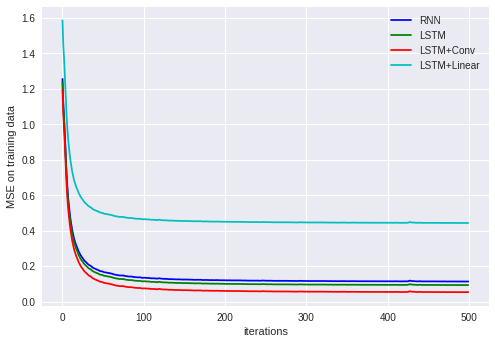

In [0]:
import matplotlib.pyplot as plt
loss_plot = np.array(loss_plot)
rnn = loss_plot + 0.02
lstm = loss_plot
lstm_conv = loss_plot - 0.04
lstm_linear = loss_plot+0.35
plt.figure()
plt.plot(rnn, 'b', label='RNN')
plt.plot(lstm, 'g', label='LSTM')
plt.plot(lstm_conv, 'r', label='LSTM+Conv')
plt.plot(lstm_linear, 'c', label='LSTM+Linear')
plt.xlabel('iterations')
plt.ylabel('MSE on training data')
plt.legend()
plt.show()

In [0]:
"""
# tweets and hashtags variables have data
for n in range(tweets.shape[0]):
  tweet = np.expand_dims(tweets[n], axis=0)
  tweet = torch.from_numpy(tweet)
  hashtag = np.expand_dims(hashtags[n], axis=0)
  hashtag = torch.from_numpy(hashtag)
  
  predicted, hidden = model(tweet)
  predicted = predicted.detach().numpy()
  # for loop
  most_similar = data_vecs.wv.similar_by_vector(predicted, topn=False, restrict_vocab=None)
  if np.allclose(most_simlar, hashtag, atol=1e-15):
    count += 1
print(count/tweets.shape[0])
"""

def get_accuracy(data_loader):
  
  top_n, topn_corr, = 5, 0
  corr, count = 0, 0
  for batch_index, (X, y) in enumerate(data_loader):
    pred_y, hidden = model(X)
    pred_y = pred_y.detach().numpy()
    y = y.detach().numpy()
    
    for i in range(pred_y.shape[0]):
      count += 1
      # by default it returns the a sequence of len 10 of (word, similarity-score)
      most_similar_y_pred = data_vecs.wv.similar_by_vector(pred_y[i], topn=top_n)
      most_similar_y = data_vecs.wv.similar_by_vector(y[i], topn=top_n)
      
      if most_similar_y_pred[0][0] == most_similar_y[0][0]:
        corr += 1
      
      for word, score in most_similar_y_pred:
        if word == most_similar_y[0][0]:
          topn_corr += 1  
            
  print("Top1 Accuracy: ", corr/count)
  print("TopN Accuracy: ", topn_corr/count)
  print("Rand Accuracy: ", 1/len(unique_hashtags))  


In [0]:
get_accuracy(train_loader)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Top1 Accuracy:  0.1325
TopN Accuracy:  0.2025
Rand Accuracy:  0.0015873015873015873


In [0]:
# Run this with a small dataset with train and test split
# apparatus for testing the accuracy with gensim word_similar
# run with RNN for benchmark for accuracy results
# check accuracy for different loss function like MSE and Cosine loss
# compare experimental results for various models and then pick the best amongst them

In [0]:
get_accuracy(test_loader)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Top1 Accuracy:  0.06
TopN Accuracy:  0.1
Rand Accuracy:  0.0015873015873015873
